In [481]:
import ML_for_WDN
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import wntr
import networkx as nx
from datetime import datetime
import traces
from datetime import timedelta
import pdb
import sklearn
from sklearn import preprocessing
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Set working directory
abs_path = '/home/ntm/PhD/ML-for-WDN/notebooks/'
os.chdir(abs_path + '..')

In [513]:
def prepare_time_series_df(df, sensors):
    df['datetime'] = \
        pd.to_datetime(df['Date'] + ' ' + df['Time'])

    df_sensors = []
    for i in sensors:
        if i < 10:
            sensor_name = f'FM0{i}'
        else:
            sensor_name = f'FM{i}'

        df_sensor_i = df.loc[df['FM.No.'] == sensor_name]

        ts_flow = traces.TimeSeries([
            (df_sensor_i['datetime'].iloc()[i], df_sensor_i['Flow(LPS)'].iloc()[i]) 
            for i in range(len(df_sensor_i))
        ])
        ts_pressure = traces.TimeSeries([
            (df_sensor_i['datetime'].iloc()[i], df_sensor_i['Pressure (bar)'].iloc()[i]) 
            for i in range(len(df_sensor_i))
        ])

        interpolated_timeseries_flow = ts_flow.sample(
            sampling_period=timedelta(minutes=1.),
            start=df['datetime'].iloc()[0],
            end=df['datetime'].iloc()[-1],
            interpolate='linear',
        )
        interpolated_timeseries_pressure = ts_pressure.sample(
            sampling_period=timedelta(minutes=1.),
            start=df['datetime'].iloc()[0],
            end=df['datetime'].iloc()[-1],
            interpolate='linear',
        )
        interpolated_df_flow = pd.DataFrame(
            interpolated_timeseries_flow, 
            columns=['datetime', f'flow_{i}']
        )
        interpolated_df_pressure = pd.DataFrame(
            interpolated_timeseries_pressure, 
            columns=['datetime', f'pressure_{i}']
        )

        df_sensor_i = pd.merge(
            interpolated_df_flow,
            interpolated_df_pressure,
            on='datetime',
        )

        df_sensors.append(df_sensor_i)

        #print(df_sensor_i)

    df_sensors = pd.concat(df_sensors, axis=1)

    df_sensors = df_sensors.loc[:,~df_sensors.columns.duplicated()].copy()

    return df_sensors





In [514]:
# Load data
df_with_leak = pd.read_csv(
    'data/raw_data/No_Leak_Experiment.csv', 
    skiprows=1
)

sensors = [1, 2, 3, 4, 6, 8, 9, 11, 13]

df = prepare_time_series_df(
    df=df_with_leak, 
    sensors=sensors
)
df = df.iloc()[2:]

df = df.set_index('datetime')

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)



In [515]:
class Dataset(Dataset):
    def __init__(self, data, window_size=10):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        x = torch.tensor(x, dtype=torch.float32)
        x = x.transpose(0, 1)
        return x


In [531]:
class UpSample(nn.Module):

    def __init__(
        self,
        channels: int,
        ) -> None:
        
        super(UpSample, self).__init__()
        
        self.conv = nn.Conv1d(channels, channels, 3, padding=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        
        return self.conv(x)

class DownSample(nn.Module):

    def __init__(
        self,
        channels: int,
        ) -> None:
        
        super(DownSample, self).__init__()
        
        self.conv = nn.Conv1d(channels, channels, 3, stride=2, padding=0)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = nn.functional.pad(x, (0, 1), mode="replicate")

        return self.conv(x)

class encoder(nn.Module):
    def __init__(
        self, 
        window_size, 
        input_channels,
        num_channels, 
        latent_dim,
        kernel_size=5,
        ):
        super(encoder, self).__init__()

        self.activation = nn.LeakyReLU()

        final_dim = window_size // 2**len(num_channels)

        if kernel_size == 3:
            self.padding = 1
        elif kernel_size == 5:
            self.padding = 2
        elif kernel_size == 7:
            self.padding = 3

        self.init_conv = nn.Conv1d(
            input_channels, 
            num_channels[0], 
            kernel_size=kernel_size, 
            stride=1, 
            padding=self.padding
            )

        self.conv_list = nn.ModuleList()
        for i in range(len(num_channels)-1):
            self.conv_list.append(
                nn.Conv1d(num_channels[i], num_channels[i+1], kernel_size=kernel_size, stride=1, padding=self.padding)
            )
        
        self.down_list = nn.ModuleList()
        for i in range(len(num_channels)):
            self.down_list.append(
                DownSample(num_channels[i])
            )

        self.batch_norm_list = nn.ModuleList()
        for i in range(len(num_channels)-1):
            self.batch_norm_list.append(
                nn.BatchNorm1d(num_channels[i+1])
            )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(num_channels[-1]*final_dim, latent_dim)

        
    def forward(self, x):

        x = self.init_conv(x)
        x = self.activation(x)
        
        for i in range(len(self.conv_list)):
            x = self.down_list[i](x)
            x = self.activation(x)
            x = self.conv_list[i](x)
            x = self.activation(x)
            x = self.batch_norm_list[i](x)

        
        x = self.down_list[-1](x)
        x = self.activation(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        
        return x


class decoder(nn.Module):
    def __init__(
        self, 
        window_size, 
        input_channels,
        num_channels, 
        latent_dim,
        kernel_size=5,
        ):
        super(decoder, self).__init__()

        self.activation = nn.LeakyReLU()

        init_dim = window_size // 2**len(num_channels)

        if kernel_size == 3:
            self.padding = 1
        elif kernel_size == 5:
            self.padding = 2
        elif kernel_size == 7:
            self.padding = 3

        self.fc = nn.Linear(latent_dim, num_channels[0]*init_dim)
        
        self.unflatten = nn.Unflatten(1, (num_channels[0], init_dim))
        
        self.up_list = nn.ModuleList()
        for i in range(len(num_channels)):
            self.up_list.append(
                UpSample(num_channels[i])
            )
        
        self.conv_list = nn.ModuleList()
        for i in range(0, len(num_channels)-1):
            self.conv_list.append(
                nn.Conv1d(num_channels[i], num_channels[i+1], kernel_size=kernel_size, stride=1, padding=self.padding)
            )

        self.batch_norm_list = nn.ModuleList()
        for i in range(len(num_channels)-1):
            self.batch_norm_list.append(
                nn.BatchNorm1d(num_channels[i+1])
            )
        
        self.final_conv = nn.Conv1d(
            num_channels[-1], 
            input_channels, 
            kernel_size=kernel_size, 
            stride=1, 
            padding=self.padding,
            bias=False,
            )

        
    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.activation(x)
        
        
        for i in range(len(self.conv_list)):
            x = self.up_list[i](x)
            x = self.activation(x)
            x = self.conv_list[i](x)
            x = self.activation(x)
            x = self.batch_norm_list[i](x)


        x = self.up_list[-1](x)
        x = self.activation(x)
        x = self.final_conv(x)

        return x

class Autoencoder(nn.Module):
    def __init__(
        self, 
        window_size, 
        input_channels,
        num_channels, 
        latent_dim,
        kernel_size=5,
        ):
        super(Autoencoder, self).__init__()

        self.encoder = encoder(
            window_size,
            input_channels,
            num_channels,
            latent_dim,
            kernel_size,
        )

        decoder_input_channels = [num_channels[i] for i in range(len(num_channels)-1, -1, -1)]
        self.decoder = decoder(
            window_size,
            input_channels,
            decoder_input_channels,
            latent_dim,
            kernel_size,
        )
        
        '''
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, num_channels[0], kernel_size=kernel_size, stride=2),
            nn.ReLU(),
            nn.Conv1d(num_channels[0], num_channels[1], kernel_size=kernel_size, stride=2),
            nn.ReLU(),
            nn.Conv1d(num_channels[1], num_channels[2], kernel_size=kernel_size, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(num_channels[2]*5, latent_dim, bias=False),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_channels[2]*5, bias=True),
            nn.ReLU(),
            nn.Unflatten(1, (num_channels[2], 5)),
            nn.ConvTranspose1d(num_channels[2], num_channels[1], kernel_size=kernel_size, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(num_channels[1], num_channels[0], kernel_size=kernel_size, stride=2, ),
            nn.ReLU(),
            nn.ConvTranspose1d(num_channels[0], input_channels, kernel_size=kernel_size, stride=2, ),
            nn.ReLU(),
        )
        '''


    def forward(self, x):

        encoder_output = self.encoder(x)

        decoder_output = self.decoder(encoder_output)
        
        #decoder_output = decoder_output[:, :, :x.shape[2]]

        return decoder_output

In [532]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

window_size = 64

num_train = int(len(df_scaled) * 0.75)
train_dataset = Dataset(data=df_scaled[:num_train], window_size=window_size)

#dataset = Dataset(data=df_scaled, window_size=window_size)
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)

model = Autoencoder(
    window_size=window_size, 
    input_channels=18,
    num_channels=[32, 16, 8], 
    latent_dim=16,
    kernel_size=5,
    )

model = model.to(device)
model.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

num_epochs = 250
pbar = tqdm(
    range(num_epochs),
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'
)
for epoch in pbar:
    for data in dataloader:
        data = data.to(device)
        recon = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    #scheduler.step(loss)

    pbar.set_postfix({'loss': loss.item()})

model.eval()


100%|██████████| 250/250 [01:27<00:00,  2.85it/s, loss=0.00166]


Autoencoder(
  (encoder): encoder(
    (activation): LeakyReLU(negative_slope=0.01)
    (init_conv): Conv1d(18, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv_list): ModuleList(
      (0): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (down_list): ModuleList(
      (0): DownSample(
        (conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
      )
      (1): DownSample(
        (conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
      )
      (2): DownSample(
        (conv): Conv1d(8, 8, kernel_size=(3,), stride=(2,))
      )
    )
    (batch_norm_list): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): dec

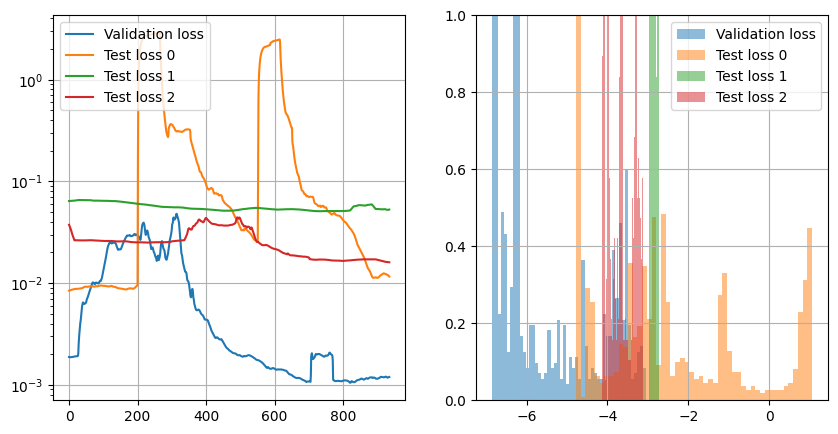

In [533]:
val_loss = []
val_recon = []
val_data = df_scaled[num_train:num_train+1000]
for i in range(0, val_data.shape[0]-window_size):
    data = val_data[i:i+window_size]
    data = torch.tensor(data, dtype=torch.float32)
    data = data.transpose(0, 1)
    data = data.unsqueeze(0)
    data = data.to(device)
    recon = model(data)
    loss = criterion(recon, data).item()
    val_loss.append(loss)

    if i % window_size == 0:
        val_recon.append(recon.detach().cpu().numpy())

val_recon = np.array(val_recon)
val_recon = val_recon[:, 0]
val_recon = val_recon.transpose(0, 2, 1)
val_recon = val_recon.reshape(-1, 18)

val_loss = np.array(val_loss)

test_recon_list = []
test_loss_list = []
df_with_leak = []
for i in range(1, 4):
    # Load data
    df_with_leak_k = pd.read_csv(
        f'data/raw_data/Leak_Location_{i}.csv', 
        skiprows=1
    )

    sensors = [1, 2, 3, 4, 6, 8, 9, 11, 13]

    df_with_leak_k = prepare_time_series_df(
        df=df_with_leak_k, 
        sensors=sensors
    )
    df_with_leak_k = df_with_leak_k.iloc()[2:]
    df_with_leak_k = df_with_leak_k.set_index('datetime')

    df_with_leak_scaled = min_max_scaler.transform(df_with_leak_k)
    df_with_leak.append(df_with_leak_scaled)

    test_loss = []
    test_recon = []
    for i in range(0, len(df_with_leak_scaled[0:1000]) - window_size):
        data = df_with_leak_scaled[i:i+window_size]
        data = torch.tensor(data, dtype=torch.float32)
        data = data.transpose(0, 1)
        data = data.unsqueeze(0)
        data = data.to(device)
        recon = model(data)
        loss = criterion(recon, data).item()
        test_loss.append(loss)

        if i % window_size == 0:
            test_recon.append(recon.detach().cpu().numpy())

    test_recon = np.array(test_recon)
    test_recon = test_recon[:, 0]
    test_recon = test_recon.transpose(0, 2, 1)
    test_recon = test_recon.reshape(-1, 18)
    test_recon_list.append(test_recon)

    test_loss = np.array(test_loss)
    test_loss_list.append(test_loss)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.semilogy(val_loss, label='Validation loss')
for i in range(3):
    plt.semilogy(test_loss_list[i], label=f'Test loss {i}')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(np.log(val_loss), bins=50, alpha=0.5, label='Validation loss', density=True)
for i in range(3):
    plt.hist(np.log(test_loss_list[i]), bins=50, alpha=0.5, label=f'Test loss {i}', density=True)
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

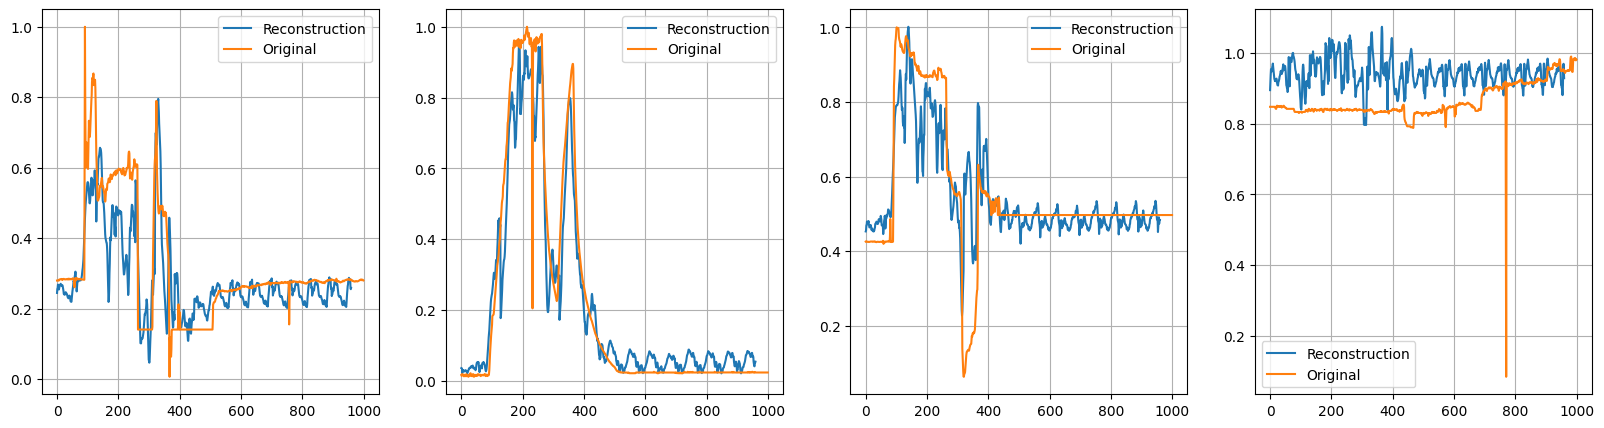

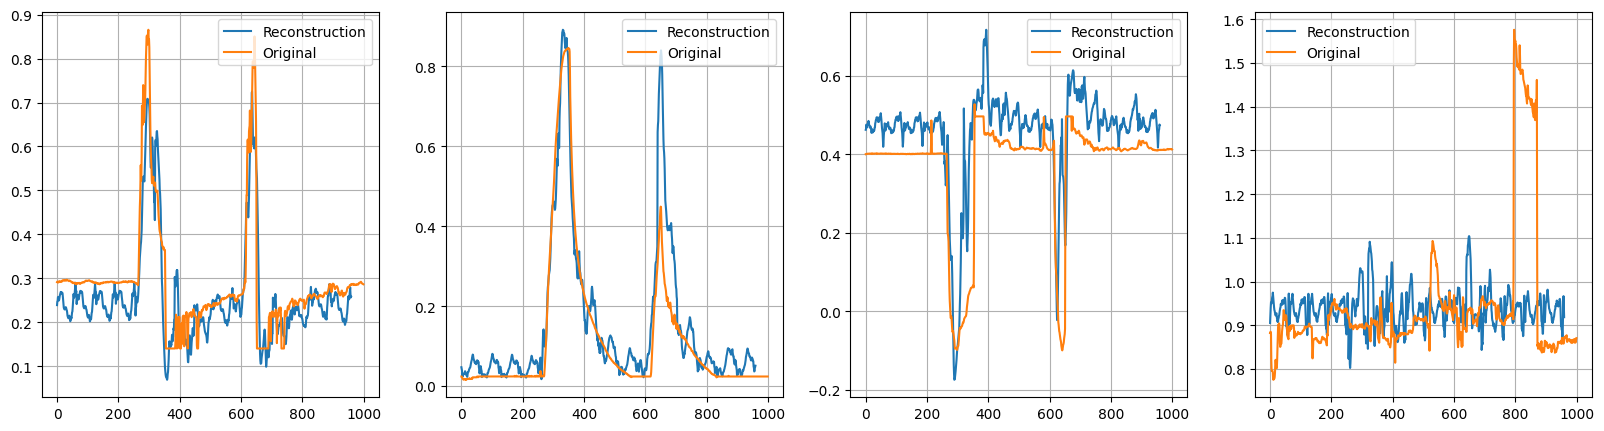

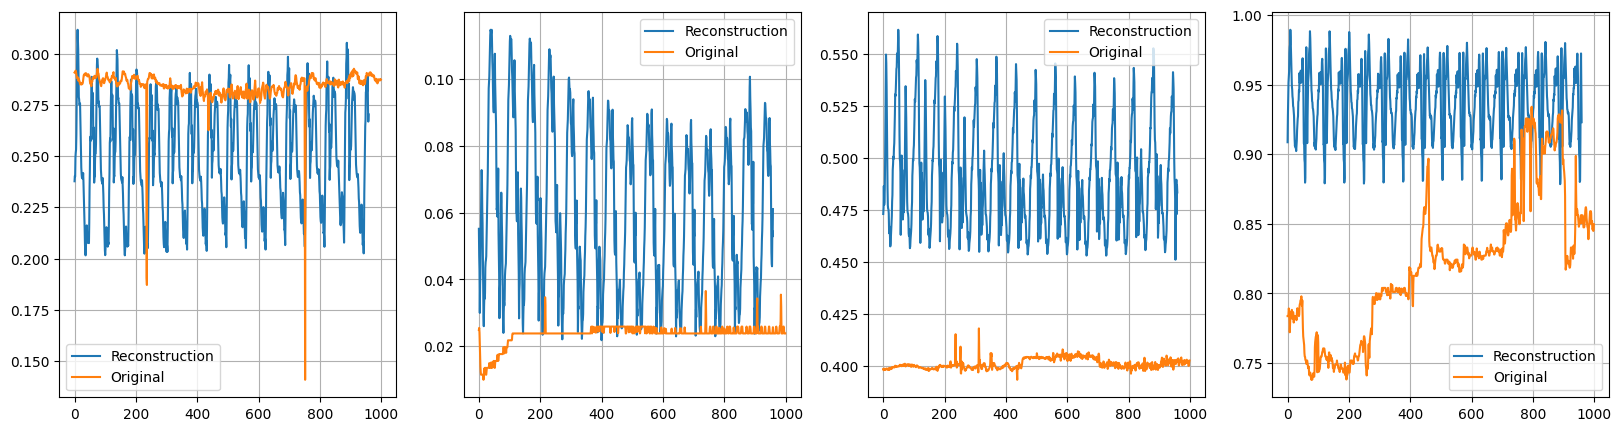

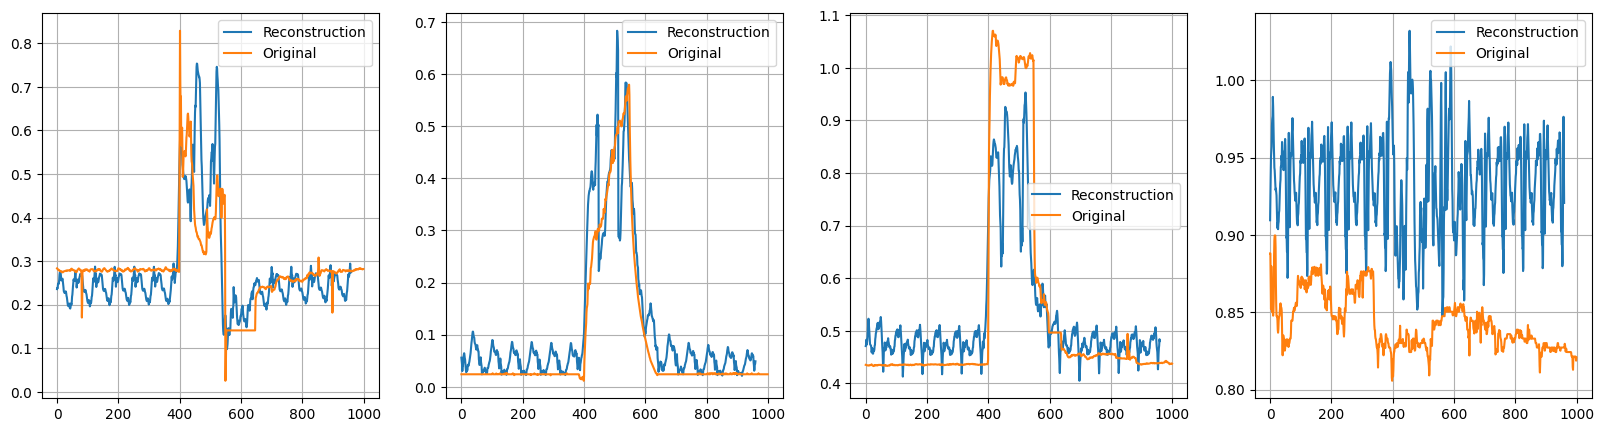

In [534]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(val_recon[:, 0], label='Reconstruction')
plt.plot(val_data[0:1000, 0], label='Original')
plt.legend()
plt.grid()
plt.subplot(1, 4, 2)
plt.plot(val_recon[:, 1], label='Reconstruction')
plt.plot(val_data[0:1000, 1], label='Original')
plt.legend()
plt.grid()
plt.subplot(1, 4, 3)
plt.plot(val_recon[:, 2], label='Reconstruction')
plt.plot(val_data[0:1000, 2], label='Original')
plt.legend()
plt.grid()
plt.subplot(1, 4, 4)
plt.plot(val_recon[:, 3], label='Reconstruction')
plt.plot(val_data[0:1000, 3], label='Original')
plt.legend()
plt.grid()
plt.show()

for i in range(3):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.plot(test_recon_list[i][:, 0], label='Reconstruction')
    plt.plot(df_with_leak[i][0:1000, 0], label='Original')
    plt.legend()
    plt.grid()
    plt.subplot(1, 4, 2)
    plt.plot(test_recon_list[i][:, 1], label='Reconstruction')
    plt.plot(df_with_leak[i][0:1000, 1], label='Original')
    plt.legend()
    plt.grid()
    plt.subplot(1, 4, 3)
    plt.plot(test_recon_list[i][:, 2], label='Reconstruction')
    plt.plot(df_with_leak[i][0:1000, 2], label='Original')
    plt.legend()
    plt.grid()
    plt.subplot(1, 4, 4)
    plt.plot(test_recon_list[i][:, 3], label='Reconstruction')
    plt.plot(df_with_leak[i][0:1000, 3], label='Original')
    plt.legend()
    plt.grid()
    plt.show()